## Generating Explanations

### Load dataset

In [18]:
import newlime_utils
import importlib
importlib.reload(newlime_utils)

dataset_folder = 'anchor-experiments/datasets/'
dataset_name = 'recidivism'
# dataset_name = 'adult'
# dataset_name = 'diabetes'
# dataset_name = 'default'
# dataset_name = 'lending'

# dataset = utils.load_dataset(
    # dataset_name, balance=True, dataset_folder=dataset_folder, discretize=True)

dataset = newlime_utils.load_dataset(dataset_name, dataset_folder, balance=True)
print(dataset.class_names)

print(dataset.train.shape[0])
print(dataset.test.shape[0])
print(dataset.train.shape[0] + dataset.test.shape[0])

['No more crimes', 'Re-arrested']
5635
705
6340


### Learn black box model

In [19]:
import sklearn.ensemble
import sklearn.neural_network

dataset = newlime_utils.load_dataset(dataset_name, dataset_folder, balance=True)

rf = sklearn.ensemble.RandomForestClassifier(n_estimators=50, n_jobs=5)
rf.fit(dataset.train, dataset.labels_train)

lr = sklearn.linear_model.LogisticRegression()
lr.fit(dataset.train, dataset.labels_train)

for model in [rf, lr]:
    print(model)
    print('Train', sklearn.metrics.accuracy_score(
        dataset.labels_train, model.predict(dataset.train)))
    print('Test', sklearn.metrics.accuracy_score(
        dataset.labels_test, model.predict(dataset.test)))

RandomForestClassifier(n_estimators=50, n_jobs=5)
Train 0.935226264418811
Test 0.7531914893617021
LogisticRegression()
Train 0.6083407275953859
Test 0.6156028368794326


### Get a sample

In [20]:
import random
from tabulate import tabulate

i = random.randint(10, dataset.test.shape[0])

# adult
# 730, 956, 1196, 1522
# i = 1443 # --- Capital Gain = 2
i = 0

# recidivism
# i = 266
# i = 599

print_info = True
write_file = False

trg, label, tab = newlime_utils.get_trg_sample(i, dataset)
if print_info:
    print(
        "Prediction:",
        dataset.class_names[model.predict(trg.reshape(1, -1))[0]],
    )
    print("True:      ", dataset.class_names[dataset.labels_test[i]])
    print(tabulate(tab))
if write_file:
    csv_name = f"img/{dataset_name}/{index:05d}-instance.csv"
    with open(csv_name, "w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerows([["feature", "value"]])
        writer.writerows(tab)

Prediction: No more crimes
True:       Re-arrested
----------------------  -------------------------------
Race                    White (1)
Alcohol                 No (0)
Junky                   No (0)
Supervised Release      Yes (1)
Married                 No (0)
Felony                  Yes (1)
WorkRelease             Yes (1)
Crime against Property  Yes (1)
Crime against Person    No (0)
Gender                  Male (1)
Priors                  1
YearsSchool             8.00 < YearsSchool <= 10.00 (1)
PrisonViolations        0
Age                     Age <= 21.00 (0)
MonthsServed            4.00 < MonthsServed <= 9.00 (1)
Recidivism              Re-arrested (1)
----------------------  -------------------------------


### LIME

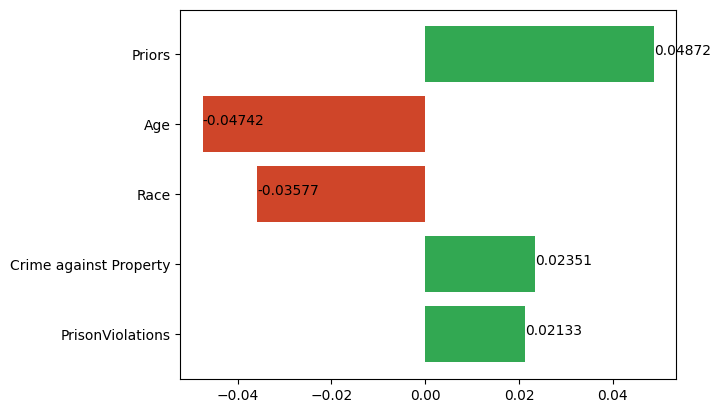

In [21]:
import matplotlib.pyplot as plt
importlib.reload(newlime_utils)

weights = newlime_utils.lime_original(trg, rf.predict([dataset.test[i]])[0], dataset, rf)
newlime_utils.plot_weights(weights, dataset.feature_names)
plt.show()

write_file = False
if write_file:
    img_file = 'img/%s/%05d-LIME.png' % (dataset_name, i)
    plt.savefig(img_file, bbox_inches='tight')

plt.close()

### Anchor

In [26]:
importlib.reload(newlime_utils)

threshold, anchor_str, prec, cov = newlime_utils.anchor_original(
    trg, dataset, rf, threshold=0.80
)
print(f"Threshold:  {threshold:.2f}")                                       
print(f"Anchor:     {anchor_str}")                                          
print(f"Precision:  {prec:.2f}")                          
print(f"Coverage:   {cov:.2f}") 

Threshold:  0.80
Anchor:     Age <= 21.00 AND Felony = Yes AND Married = No AND 8.00 < YearsSchool <= 10.00 AND Crime against Property = Yes AND WorkRelease = Yes
Precision:  0.83
Coverage:   0.01


### New LIME

0.6


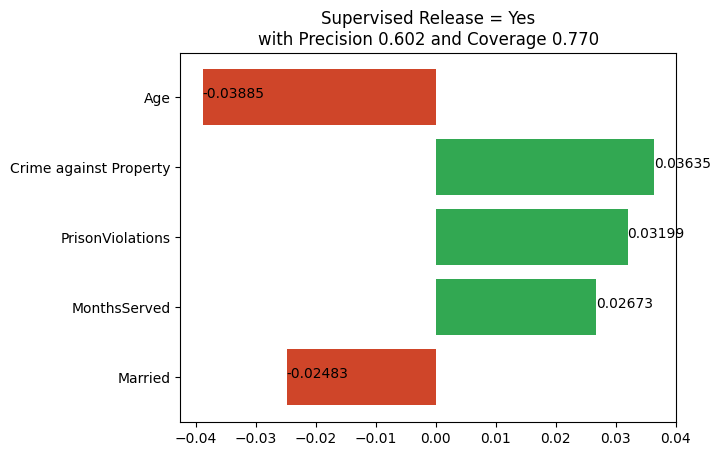

In [55]:
import newlime_tabular
import newlime_base
importlib.reload(newlime_tabular)
importlib.reload(newlime_utils)
importlib.reload(newlime_base)

write_file = False

# i = random.randint(10, dataset.test.shape[0])
# i = 0
# trg, trg_label = newlime_utils.sample(i, dataset, dataset_name, rf)

newlime_explainer = newlime_tabular.NewLimeTabularExplainer(
    dataset.class_names, dataset.feature_names, dataset.train, dataset.categorical_names
)
for t in [0.60]:  # [0.70, 0.80, 0.90, 0.95]:
    print(t)
    hyper_param = newlime_tabular.HyperParam(
        delta = 0.05,
        epsilon = 0.1, 
        epsilon_stop = 0.05,
        beam_size = 10,
        batch_size = 100,
        desired_confidence = t,
        coverage_samples_num = 10000,
        max_rule_length = None,
    )
    result = newlime_explainer.my_explain_instance(
        trg, rf.predict, hyper_param
    )
    if result is not None:
        anchor_exp, surrogate_model = result
        if surrogate_model is not None:
            weights = list(surrogate_model["LogisticRegression"].weights.values())
            newlime_utils.plot_weights(weights, dataset.feature_names, anchor_exp)
            if write_file:
                img_file = 'img/%s/%05d-%03d.png' % (dataset_name, i, t * 100)
                plt.savefig(img_file, bbox_inches='tight')

## Imbalanced Data

### Check balance of datasets

In [24]:
import importlib
importlib.reload(newlime_base)
importlib.reload(newlime_tabular)
importlib.reload(newlime_utils)

for dataset_name in ["adult", "recidivism", "lending"]:
    print(dataset_name)
    balanced = newlime_utils.load_dataset(dataset_name, dataset_folder, balance=True)
    imbalanced = newlime_utils.load_dataset(dataset_name, dataset_folder, balance=False)
    for d, s in zip([balanced, imbalanced], ["Balanced:   ", "Imbalanced: "]):
        label_count = [0, 0]
        for l in [int(x) for x in d.labels_train.tolist()]:
            label_count[l] += 1
        print(s, label_count)
    print()

NameError: name 'newlime_base' is not defined

### Undersampling

In [ ]:
import numpy as np

dataset_folder = 'anchor-experiments/datasets/'
dataset_name = 'recidivism'
dataset = newlime_utils.load_dataset(dataset_name, dataset_folder, balance=False)

print(dataset.train.shape)
print(dataset.labels_train.shape)
print(dataset.train_idx.shape)

print(dataset.validation.shape)
print(dataset.labels_validation.shape)
print(dataset.validation_idx.shape)

print(dataset.test.shape)
print(dataset.labels_test.shape)
print(dataset.test_idx.shape)

# get indexes of data rows that will be deleted
minor_class = 1
minor_data_num = 80
minor_data_idx = []
for i, l in enumerate(dataset.labels):
    if l == minor_class:
        minor_data_idx.append(i)
np.random.seed(1024)
del_list = np.random.choice(
    minor_data_idx,
    len(minor_data_idx) - minor_data_num,
    replace=False,
)

del_train_list = []
for i, x in enumerate(dataset.train_idx):
    if x in del_list:
        del_train_list.append(i)

del_valid_list = []
for i, x in enumerate(dataset.validation_idx):
    if x in del_list:
        del_valid_list.append(i)

del_test_list = []
for i, x in enumerate(dataset.test_idx):
    if x in del_list:
        del_test_list.append(i)

label_count = [0, 0]
for l in [int(x) for x in dataset.labels_train.tolist()]:
    label_count[l] += 1
print(label_count)

label_count = [0, 0]
for l in [int(x) for x in dataset.labels_validation.tolist()]:
    label_count[l] += 1
print(label_count)

label_count = [0, 0]
for l in [int(x) for x in dataset.labels_test.tolist()]:
    label_count[l] += 1
print(label_count)

dataset.data = np.delete(dataset.data, del_list, axis=0)
dataset.labels = np.delete(dataset.labels, del_list, axis=0)

dataset.train = np.delete(dataset.train, del_train_list, axis=0)
dataset.labels_train = dataset.data = np.delete(dataset.labels_train, del_train_list, axis=0)
dataset.train_idx = np.delete(dataset.train_idx, del_train_list, axis=0)

dataset.validation = np.delete(dataset.validation, del_valid_list, axis=0)
dataset.labels_validation = np.delete(dataset.labels_validation, del_valid_list, axis=0)
dataset.validation_idx = np.delete(dataset.validation_idx, del_valid_list, axis=0)

dataset.test = np.delete(dataset.test, del_test_list, axis=0)
dataset.labels_test = np.delete(dataset.labels_test, del_test_list, axis=0)
dataset.test_idx = np.delete(dataset.test_idx, del_test_list, axis=0)

label_count = [0, 0]
for l in [int(x) for x in dataset.labels_train.tolist()]:
    label_count[l] += 1
print(label_count)

label_count = [0, 0]
for l in [int(x) for x in dataset.labels_validation.tolist()]:
    label_count[l] += 1
print(label_count)

label_count = [0, 0]
for l in [int(x) for x in dataset.labels_test.tolist()]:
    label_count[l] += 1
print(label_count)

print(dataset.train.shape)
print(dataset.labels_train.shape)
print(dataset.train_idx.shape)

print(dataset.validation.shape)
print(dataset.labels_validation.shape)
print(dataset.validation_idx.shape)

print(dataset.test.shape)
print(dataset.labels_test.shape)
print(dataset.test_idx.shape)

In [ ]:
import importlib
importlib.reload(newlime_base)
importlib.reload(newlime_tabular)
importlib.reload(newlime_utils)

t = 0.8
num_calc = 1000

covs = []
for i in range(num_calc):
    trg, trg_label = sample(None, dataset, dataset_name, print_info=False)
    result = new_lime(
        trg, 
        dataset, 
        threshold=t, 
        beam_size=1, 
        epsilon=0.1, 
        my_verbose=True, 
        print_info=False
    )
    if result is None:
        print("None")
        i -= 1
        continue
    _, _, cov = result
    covs.append(cov)
    print(cov)
    print(i + 1, "/", num_calc)
    
print(np.average(covs))
print(np.std(covs))

In [ ]:
balanced = newlime_utils.load_dataset(dataset_name, dataset_folder, balance=True)

covs = []
for i in range(num_calc):
    trg, trg_label = sample(None, balanced, dataset_name, print_info=False)
    result = new_lime(
        trg, 
        balanced, 
        threshold=t, 
        beam_size=1, 
        epsilon=0.1, 
        my_verbose=True, 
        print_info=False,
    )
    if result is None:
        print("None")
        i -= 1
        continue
    _, _, cov = result
    covs.append(cov)
    print(cov)
    print(i + 1, "/", num_calc)
print(np.average(covs))
print(np.std(covs))